# Снижение размерности. Алгоритм PCA

Данные столбцов:

- culmen_length_mm: длина верхнего края клюва пингвина (миллиметр)

- culmen_depth_mm: глубина верхнего края клюва пингвина (миллиметр)

- flipper_length_mm: длина ласт (миллиметр)

- body_mass_g: масса тела (грамм)

- sex: пол пингвина 

## Импортируем данные

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE

import umap
from umap import UMAP # umap-learn библиотека

from sklearn.preprocessing import StandardScaler, LabelEncoder

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('penguins.csv')
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


## Проведем EDA (Exploratory Data Analysis) - первичный анализ данных

In [4]:
# Функция для числовых столбцов
def eda_num_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Минимальное значение": df.min(),
            "Максимальное значение": df.max(),
            "Среднее значение": df.mean(),
            "Медиана": df.median(),
            "Дисперсия": df.var(),
            "Квантиль 0.1": df.quantile(0.1),
            "Квантиль 0.9": df.quantile(0.9),
            "Квартиль 1": df.quantile(0.25),
            "Квартиль 3": df.quantile(0.75)
        }
    )

    return x

In [5]:
# Функция для категориальных столбцов
def eda_cat_info(df):
    x = pd.DataFrame(
        {
            "Доля пропусков": df.isnull().mean(),
            "Количество уникальных значений": df.nunique(),
            "Мода": df.mode().iloc[0]
        }
    )
    
    return x

In [6]:
col_num = df.select_dtypes(include=["number"]).columns
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.005814,32.1,59.6,43.921930,44.45,29.807054,36.6,50.8,39.225,48.50
culmen_depth_mm,0.005814,13.1,21.5,17.151170,17.30,3.899808,14.3,19.5,15.600,18.70
flipper_length_mm,0.005814,-132.0,5000.0,214.014620,197.00,67890.501252,185.0,221.0,190.000,213.75
body_mass_g,0.005814,2700.0,6300.0,4201.754386,4050.00,643131.077327,3300.0,5400.0,3550.000,4750.00


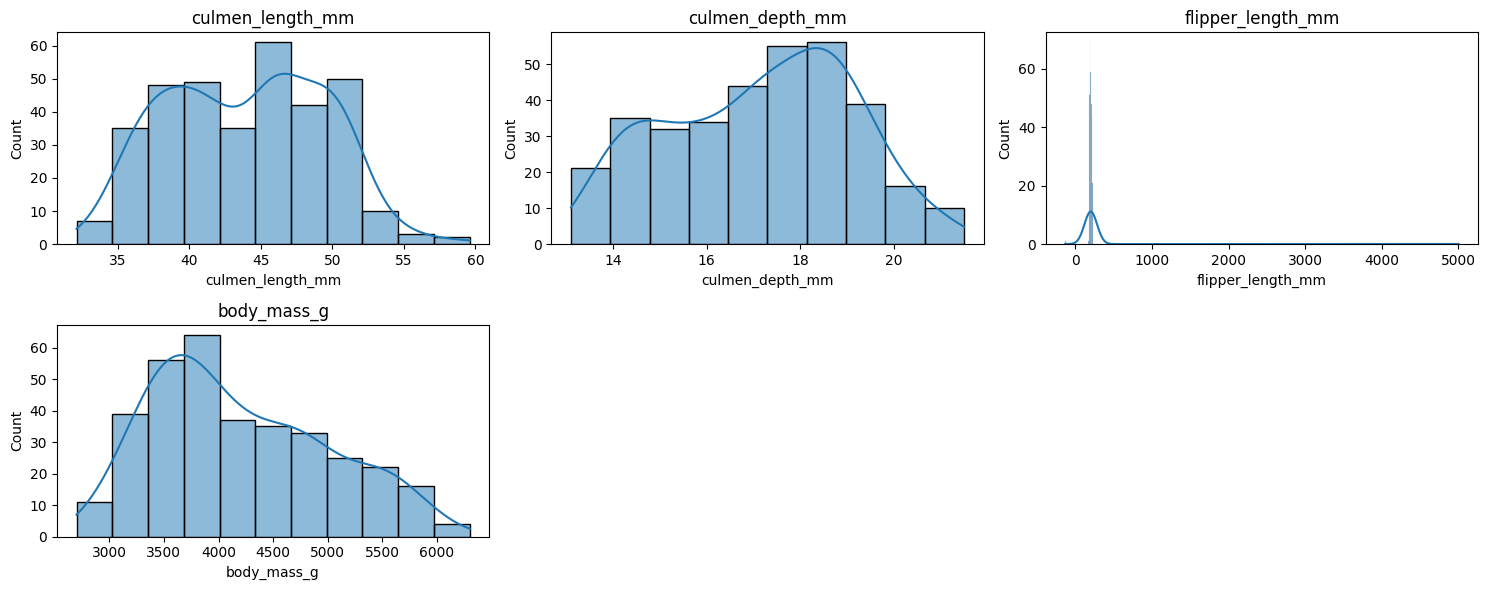

In [7]:
# Визуализация гистограмм
def plot_histograms(df):
    # Определить количество строк и столбцов для подграфиков
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    
    # Создать фигуру с нужным размером
    plt.figure(figsize=(n_cols * 5, n_rows * 3))
    
    for i, column in enumerate(df.columns, start=1):
        plt.subplot(n_rows, n_cols, i)
        sns.histplot(df[column], kde=True)
        
        # Добавить название столбца как заголовок графика
        plt.title(column)
        
    plt.tight_layout()
    plt.show()

# Применение функции к DataFrame df
plot_histograms(df[col_num])

Видим, что гистограмма длины ласт (*flipper_lenght_mm*) пингвинов имеет выбросы и отрицательные значения. Остальные данные в порядке.

In [8]:
col_cat = df.select_dtypes(include=["object"]).columns
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.026163,3,MALE


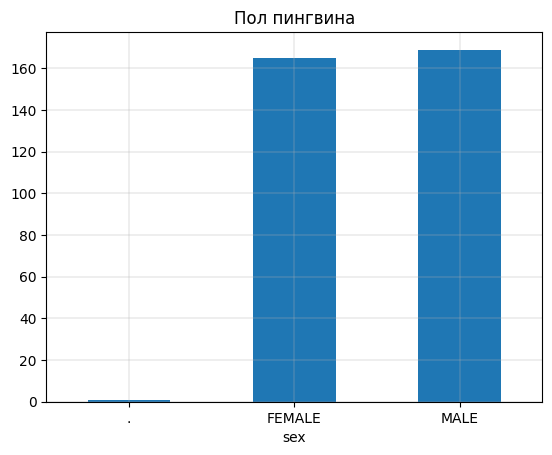

In [9]:
df['sex'].value_counts().sort_index().plot(kind='bar')
plt.xticks(rotation=0)
plt.grid(linewidth=0.3)
plt.title('Пол пингвина')
plt.show()

In [10]:
df['sex'].unique()

array(['MALE', 'FEMALE', nan, '.'], dtype=object)

In [11]:
df['sex'].value_counts()

sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

Видим, что помимо пропусков данных в столбце пола имеется аномалия - третье значение, обозначенное `.`. Заменим эту аномалию модой.

In [12]:
df['sex'].replace('.', df['sex'].mode()[0], inplace=True)

In [13]:
df['sex'].unique()

array(['MALE', 'FEMALE', nan], dtype=object)

In [14]:
df['sex'].value_counts()

sex
MALE      170
FEMALE    165
Name: count, dtype: int64

## Обработка пропусков

In [15]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
dtype: int64

Количество пропусков в категориальных столбцах:
sex    9
dtype: int64


In [16]:
# Заполняем пропуски числовых переменных медианой
df[col_num] = df[col_num].fillna(df[col_num].median())

In [17]:
# Заполненяем пропуски модой
for column in col_cat:
    mode_value = df[column].mode()[0]  # Получение моды
    df.fillna({column: mode_value}, inplace=True)  # Заполнение пропусков модой

In [18]:
print("Количество пропусков в числовых столбцах:")
print(df[col_num].isnull().sum())
print("\nКоличество пропусков в категориальных столбцах:")
print(df[col_cat].isnull().sum())

Количество пропусков в числовых столбцах:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
dtype: int64

Количество пропусков в категориальных столбцах:
sex    0
dtype: int64


## Проверка на выбросы в данных

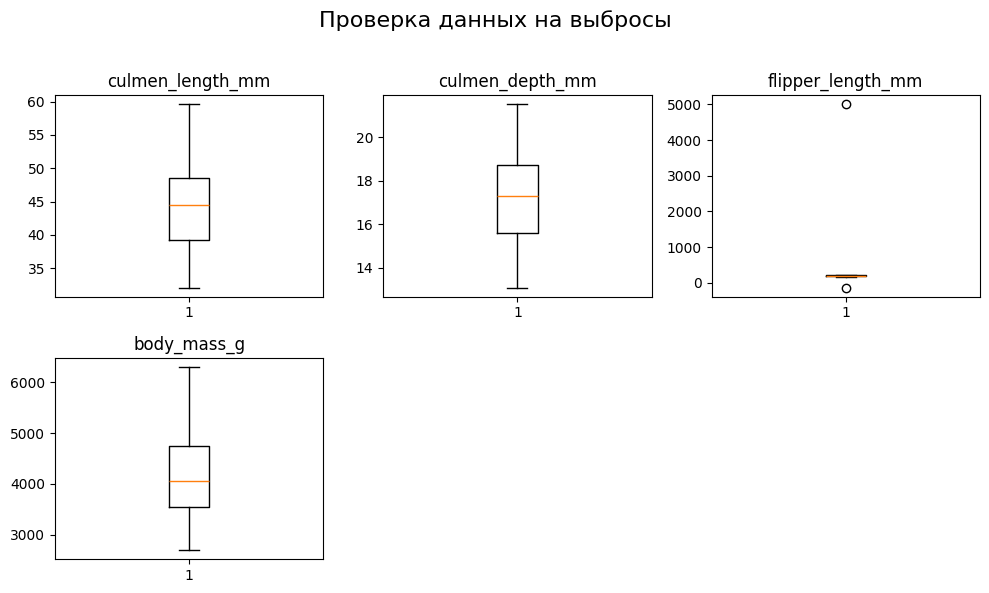

In [19]:
n = len(col_num)
ncols = 3  # Количество столбцов в сетке
nrows = (n + ncols - 1) // ncols  # Количество строк

# Создание фигуры и подграфиков
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 3 * nrows))
axes = axes.flatten()  # Преобразование в одномерный массив для удобства

# Создание boxplot для каждого числового столбца
for i, column in enumerate(col_num):
    axes[i].boxplot(df[column])
    axes[i].set_title(column)  # Заголовок для каждого графика

# Удаление пустых подграфиков, если они есть
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
fig.suptitle("Проверка данных на выбросы", fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Автоматическая настройка отступов
plt.show()  # Отображение графиков

In [20]:
df['flipper_length_mm'].sort_values(ascending=False).head()

9      5000.0
283     231.0
285     230.0
295     230.0
253     230.0
Name: flipper_length_mm, dtype: float64

In [21]:
df['flipper_length_mm'].sort_values().head()

14    -132.0
28     172.0
20     174.0
122    176.0
30     178.0
Name: flipper_length_mm, dtype: float64

Видим два аномальных значения в данных: 5000 мм и -132. Обработаем данные выбросы.

In [22]:
# Обработаем выбросы
def outliers_in_data(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q3 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])
    
    return df


df = outliers_in_data(df, ['flipper_length_mm'])

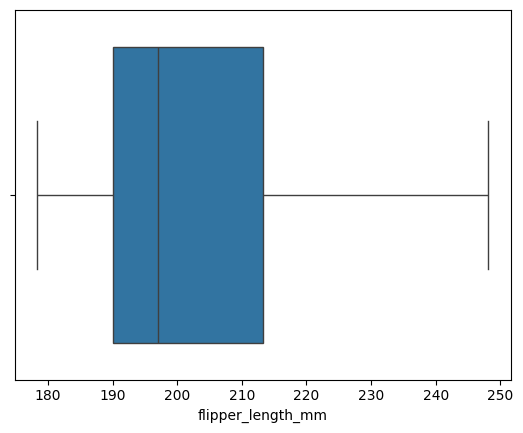

In [23]:
sns.boxplot(data=df, x='flipper_length_mm')
plt.show()

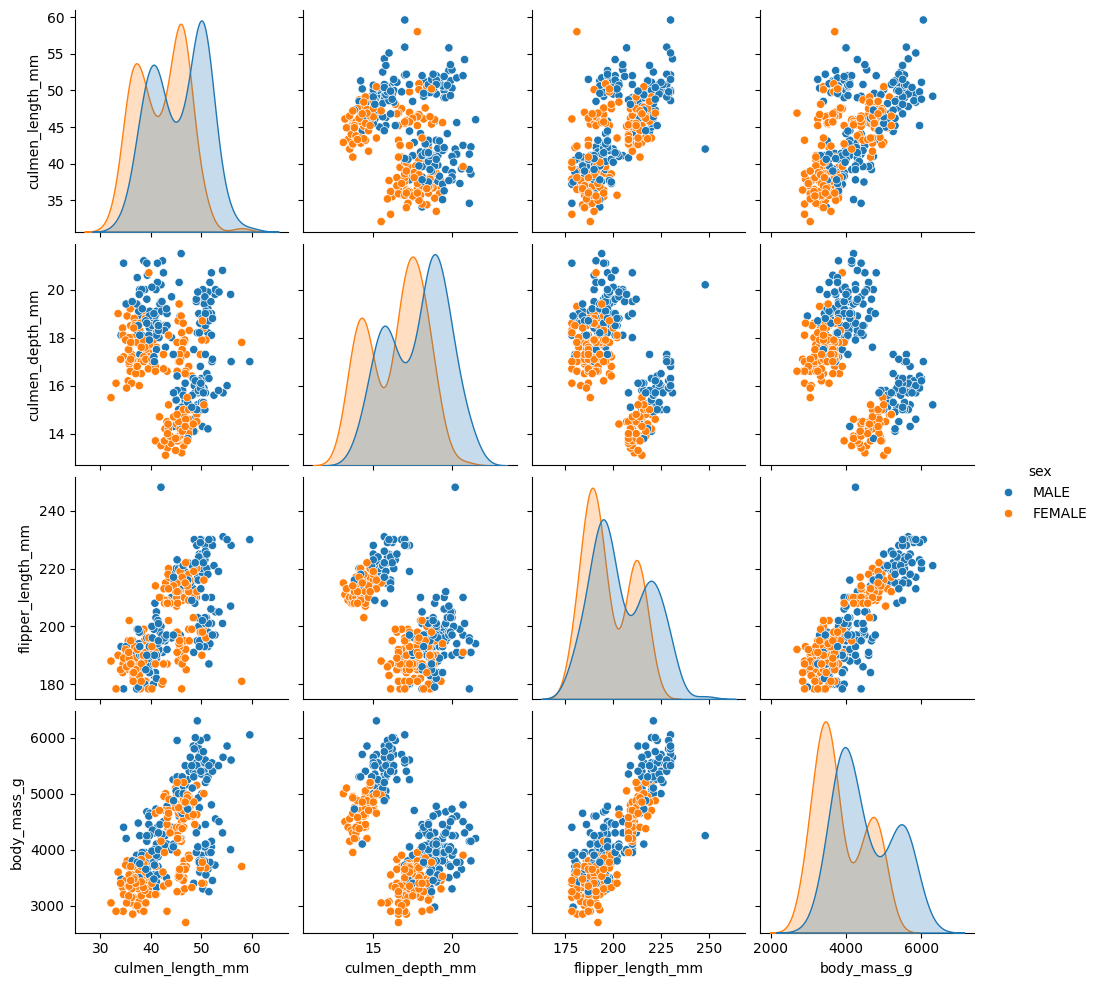

In [24]:
sns.pairplot(df, hue='sex')
plt.show()

## Проведем EDA после обработки

In [25]:
eda_num_info(df[col_num])

,Доля пропусков,Минимальное значение,Максимальное значение,Среднее значение,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
culmen_length_mm,0.0,32.100,59.600,43.925000,44.45,29.634869,36.6,50.8,39.275,48.50
culmen_depth_mm,0.0,13.100,21.500,17.152035,17.30,3.877197,14.3,19.5,15.600,18.70
flipper_length_mm,0.0,178.375,248.125,201.046875,197.00,202.143250,185.0,221.0,190.000,213.25
body_mass_g,0.0,2700.000,6300.000,4200.872093,4050.00,639514.543359,3300.0,5400.0,3550.000,4750.00


In [26]:
eda_cat_info(df[col_cat])

,Доля пропусков,Количество уникальных значений,Мода
sex,0.0,2,MALE


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   344 non-null    float64
 1   culmen_depth_mm    344 non-null    float64
 2   flipper_length_mm  344 non-null    float64
 3   body_mass_g        344 non-null    float64
 4   sex                344 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


Пропуски и выбросы обработаны.

## Построим матрицу корреляции

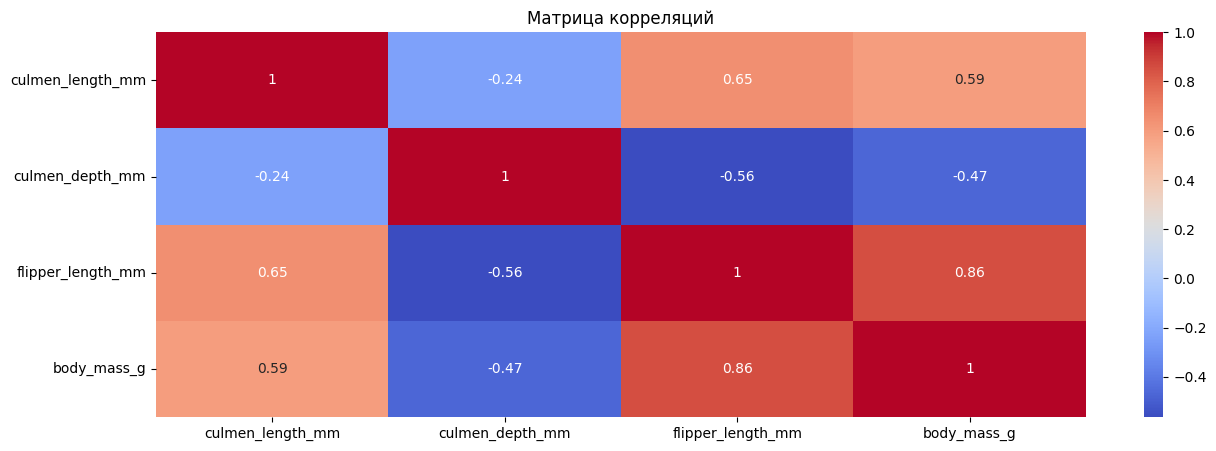

In [28]:
corr = df[col_num].corr()
plt.figure(figsize=(15,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Матрица корреляций")
plt.show()

Видим хорошую корреляцию между `flipper_length_mm и body_mass_g`, а также между `flipper_length_mm и culmen_length_mm`.

## Кодирование категориальных столбцов

In [29]:
# Кодирование категориального признака 'sex'
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])

df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.10,18.7,181.0,3750.0,1
1,39.50,17.4,186.0,3800.0,0
2,40.30,18.0,195.0,3250.0,0
3,44.45,17.3,197.0,4050.0,1
4,36.70,19.3,193.0,3450.0,0


## Нормализация данных

In [30]:
# Нормализация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[col_num])
pd.DataFrame(X_scaled).head()

,0,1,2,3
0,-0.887622,0.787289,-1.412047,-0.564625
1,-0.814037,0.126114,-1.059861,-0.502010
2,-0.666866,0.431272,-0.425925,-1.190773
3,0.096581,0.075255,-0.285051,-0.188936
4,-1.329133,1.092447,-0.566800,-0.940314


## Снижение размерности до 2 (n_components=2)

### Применение Kernel PCA

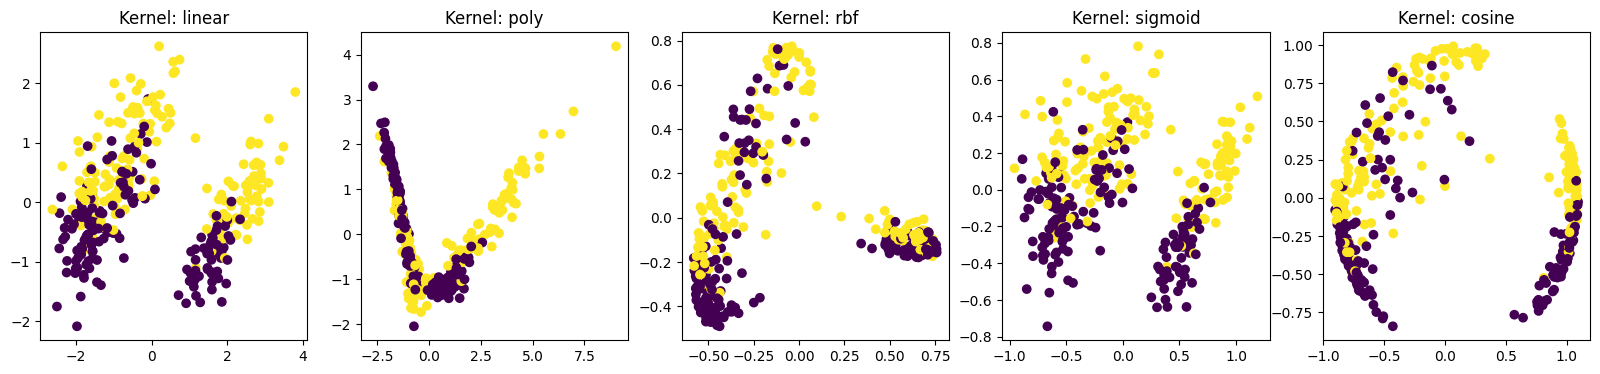

In [31]:
# Применение Kernel PCA (для размерности 2)
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, kernel in enumerate(kernels):
    kpca = KernelPCA(n_components=2, kernel=kernel) # размерность n_components=2
    X_kpca = kpca.fit_transform(X_scaled)
    axes[i].scatter(X_kpca[:, 0], X_kpca[:, 1], c=df['sex'], cmap='viridis')
    axes[i].set_title(f'Kernel: {kernel}')
plt.show()

- Linear – сохраняет глобальную структуру данных, но плохо работает с нелинейными зависимостями.
- Poly – добавляет больше гибкости, может лучше разделять данные, в отличие от линейного ядра.
- RBF – захватывает сложные нелинейные зависимости, показывает четкие границы между классами.
- Sigmoid – менее четкое разделение данных.
- Cosine – это ядро используется для сравнения углов между векторами. На графике может быть видно, как классы группируются в зависимости от углов, а не расстояний.

### Оценка дисперсии для линейного ядра

In [32]:
kpca_linear = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
X_kpca_linear = kpca_linear.fit_transform(X_scaled)
explained_variance = np.var(X_kpca_linear, axis=0)
total_variance = np.var(X_scaled, axis=0).sum()
lost_variance = 1 - explained_variance.sum() / total_variance
print(f'Lost variance for linear kernel: {lost_variance:.4f}')

Lost variance for linear kernel: 0.1244


Для линейного ядра потеря дисперсии (lost_variance) показывает, сколько информации было потеряно при снижении размерности: `12.44%`

### Применение t-SNE

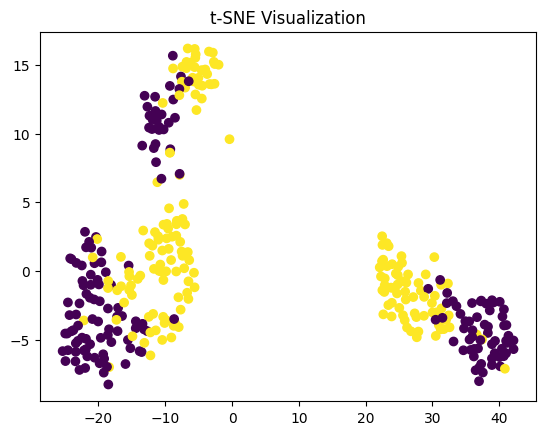

In [33]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['sex'], cmap='viridis')
plt.title('t-SNE Visualization')
plt.show()

Имеется хорошая различимость между классами. В нашем случае это пол пингвинов - мужской и женский. Видим что классы перекрываются или смешиваются, это может указывать на то, что данные не являются хорошо разделенными и между классами может быть больше общего, чем предполагалось изначально. Также можно наблюдать различные плотности баллов в разных областях графика, указывающие на разброс данных. Высокая плотность в определенных областях может указывать на более частые наблюдения.

### Применение UMAP

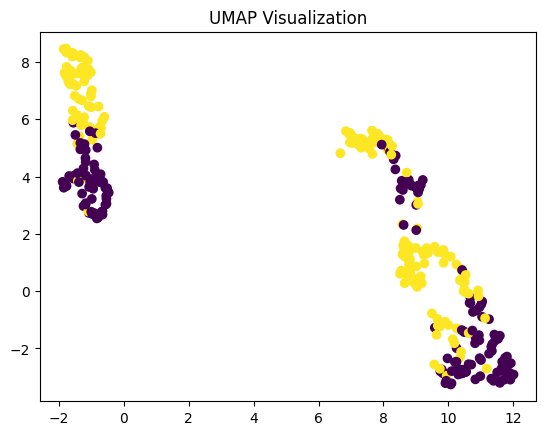

In [34]:
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=df['sex'], cmap='viridis')
plt.title('UMAP Visualization')
plt.show()

Более четкие и отдельные кластеры указывают на то, что данные хорошо разделимы по классу пола пингвинов. Точки одного класса перекрываются с точками другого класса, это может говорить о том, что между классами есть определенное сходство. Это перекрытие также может свидетельствовать о том, что какая-то информация из других признаков (кроме *sex*) может быть важной для различения между классами. UMAP также позволяет увидеть общую структуру распределения данных. Например, если точки равномерно распределены в пространстве или если есть длинные цепочки или ножки, это может указывать на интересные паттерны, которые могут быть исследованы дальше.

## Снижение размерности до 3 (n_components=3)

### Применение Kernel PCA

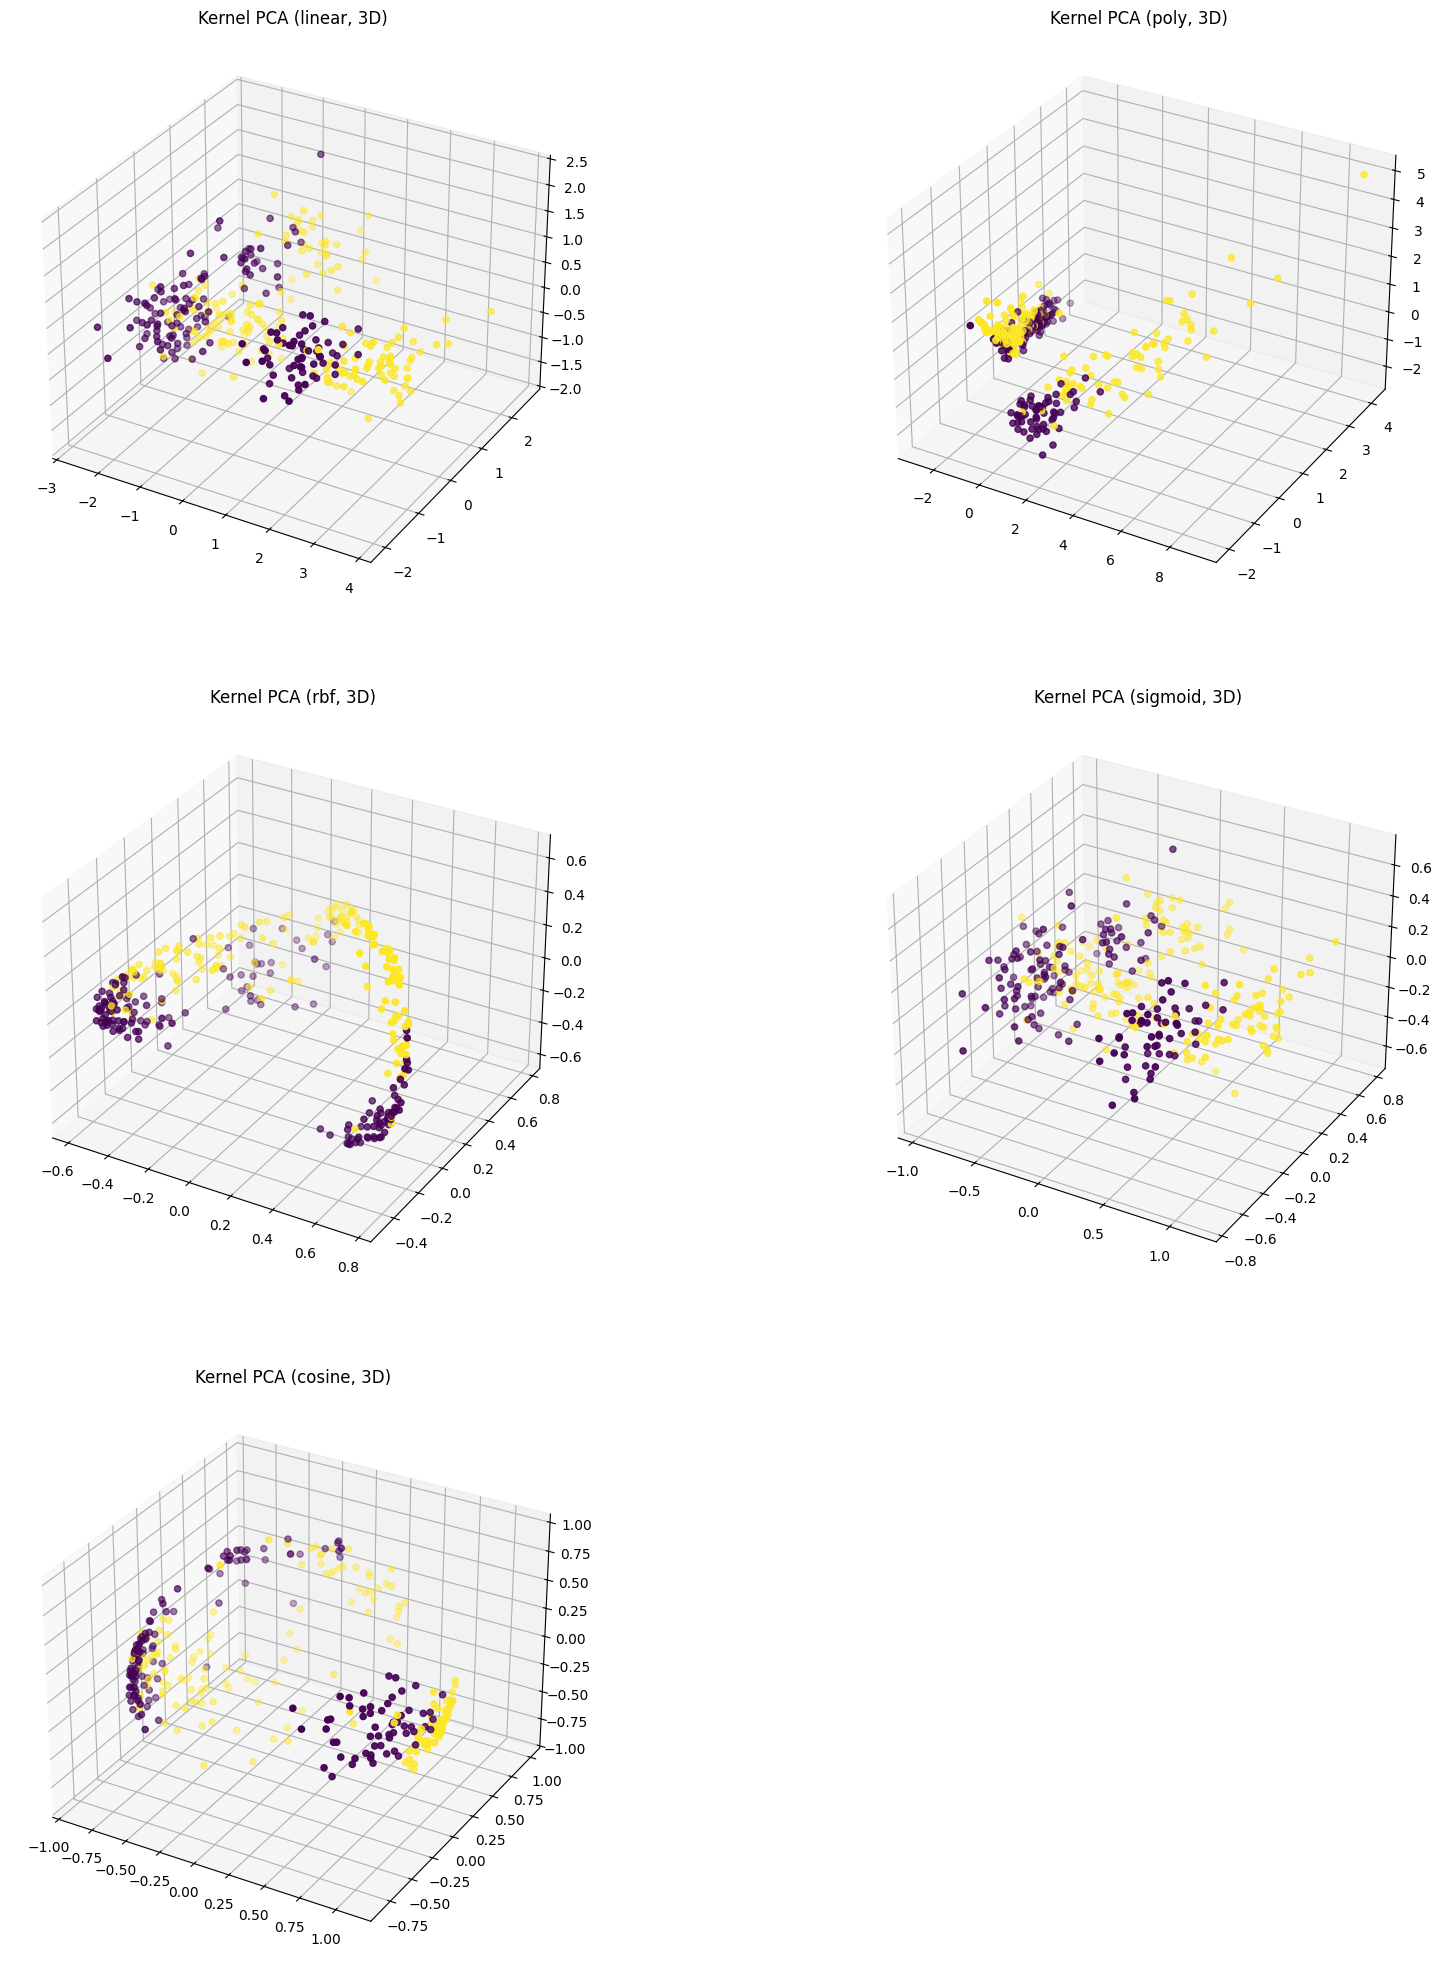

In [35]:
# Применение Kernel PCA с 3 компонентами
kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'cosine']
fig = plt.figure(figsize=(20, 25))

for i, kernel in enumerate(kernels):
    ax = fig.add_subplot(3, 2, i+1, projection='3d')
    kpca = KernelPCA(n_components=3, kernel=kernel)
    X_kpca = kpca.fit_transform(X_scaled)
    ax.scatter(X_kpca[:, 0], X_kpca[:, 1], X_kpca[:, 2], c=df['sex'], cmap='viridis')
    ax.set_title(f'Kernel PCA ({kernel}, 3D)')

plt.show()

### Оценка дисперсии для линейного ядра

In [36]:
# Оценка дисперсии для линейного ядра
kpca_linear = KernelPCA(n_components=3, kernel='linear', fit_inverse_transform=True)
X_kpca_linear = kpca_linear.fit_transform(X_scaled)
explained_variance = np.var(X_kpca_linear, axis=0)
total_variance = np.var(X_scaled, axis=0).sum()
lost_variance = 1 - explained_variance.sum() / total_variance
print(f'Lost variance for linear kernel: {lost_variance:.4f}')

Lost variance for linear kernel: 0.0324


Для линейного ядра потеря дисперсии (lost_variance) показывает, сколько информации было потеряно при снижении размерности: `3.24%`

### Применение t-SNE

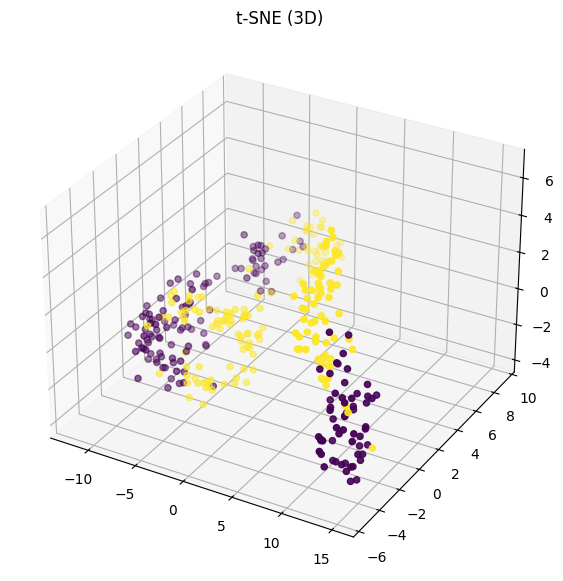

In [37]:
# Применение t-SNE (3 компоненты)
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=df['sex'], cmap='viridis')
ax.set_title('t-SNE (3D)')
plt.show()

### Применение UMAP

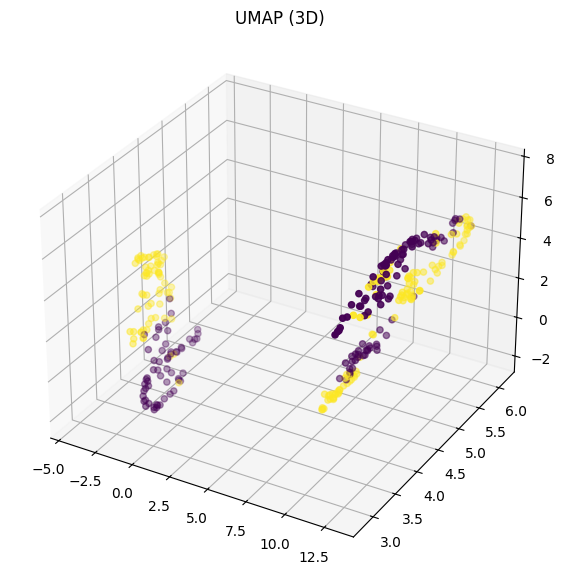

In [38]:
# Применение UMAP (3 компоненты)
umap_model = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c=df['sex'], cmap='viridis')
ax.set_title('UMAP (3D)')
plt.show()

Видим, что при *n_components=3* мы переходим в 3D пространство, при этом основная структура на графиках в 2D и 3D пространствах особо не отличаются.

Уменьшение размерности до 4 и более будет сложно визуализировать, так как мы не можем напрямую изобразить 4D-пространство. 